In [102]:
import numpy as np 
import copy
import torch
import time

from IMP_CW_env import MESCEnv
from utils import plot_reward_evolution, plot_reward_distribution, setup_model_saving

%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt

# **1. Training environment definition**

The goal of this coursework is to find an inventory policy that learns the optimal way of placing orders, that is, the one that maximizes episodic returns. The policy model should therefore inform the decision-maker about when to place a replenishment order and the quantity to order to fulfill customers' demand.

Inventory optimizaiton is a sequential decision-making problem by nature. Thus, it can be modeled as a Markov Decision Process (MDP), which is the backbone of Reinforcement Learning (RL). The underlying mathematical model is implemented in the environment `MSCEnv`, which represents multi-echelon supply chains like with the structure shown below.

<p align="center">
  <img src="bf9e11e1443535de14d158d0ab0415b2aa469261.png" alt="SupplyChainStructure" width="200"/>
</p>

In [ ]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]
time_horizon = 4*7
env_train = MESCEnv(supply_chain_structure, num_periods = time_horizon)

# **2. Policy Network**
[comment]: <> (MLPregresor from sklearn is not used because you cannot specify input and output shapes prior to calling the fit method. Since in the ES approach it won't be used, we build NN using Pytorch.)

The inventory policy is modeled with a neural network that takes the current state (i.e., inventory position at a given time step) as input, and predicts the replenishment order placed by each one of the entities of the supply chain. Since action space is continuous, the output of the network gives the mean value of the actions.

In [104]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, h1_size = 128, h2_size = 64): 
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h1_size)
        self.fc2 = torch.nn.Linear(h1_size, h2_size)
        self.fc3 = torch.nn.Linear(h2_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# **3. Policy optimization**
To obtain the optimal policies, different methods can be used. 
- **Heuristic methods** that rely on classic inventory control policies, like the (s,S) policy
- **Meta-heuristic algorithms** that iteratively explore the search space by mimiking natural phenomena, like simulated annealing (SA) or particle-swarm optimization (PSO).
- **RL-specific algorithms**, such as Q-learning or REINFORCE.

#### **Objective function**

The function `reward_fcn` is used to compute the total undiscounted return obtained following a given inventory policy. 

In this environment, custormers' demand follow a mixture of Poisson distributions, each with a different expectation depending on the day of the week. Due to the stochasticity of the environment, this value can significantly change among episodes. For this reason, the function `reward_fcn` averages the performance of the policy across different episodes. 

In [ ]:
def reward_fcn(policy_net, env, num_episodes=10, demand=None):
    '''
    Runs a series of episodes and computes the average total return.

    Arguments:
    - policy_net --> Neural network that predicts the optimal action given the state 
    - env --> Instance of MESCEnv environment
    - num_episodes --> Number of runs or episodes to estimate the average return (optional, default: 10)
    - demand --> List of scenario sets, containing realizations of customers' demand for each time step of each episode (optional, default: None)

    Returns:
    - mean_reward --> Average reward across runs
    - std_reward --> Standar deviation across runs
    '''
    # Input checking
    assert num_episodes > 0, "Number of episodes must be greater than 0"
    
    # Fix customer demand (if provided)
    env.demand_dataset = demand

    # Initialize buffer list to store results of each run
    reward_list = []

    # Run each episode and compute total undiscounted reward
    for i in range(num_episodes):
        # Reset environment before each episode
        env.reset()
        state = env.state
        episode_terminated = False
        # Initialize reward counter
        total_reward = 0
        
        while episode_terminated == False:
            # Pre-process state
            state = torch.FloatTensor(state)

            # Get action according to the policy network
            action_mean = policy_net(state)
            action_mean = action_mean.detach().numpy()
            action_mean = np.floor(action_mean)
            
            # Interact with the environment to get reward and next state
            state , reward, episode_terminated, _ = env.step(action_mean)
            total_reward += reward
            
        reward_list.append(total_reward)

    # Compute mean and standard deviation
    mean_reward = np.mean(reward_list)
    std_reward = np.std(reward_list)
    
    return mean_reward, std_reward

#### **Helper Functions**

Before getting into the actual implementation of the optimisation algorithm, two functions have been pre-coded for you:

* `sample_uniform_params` --> samples a random point within given parameter bounds.
* `sample_local_params` --> sample a random point in the neighborhood of a given point.

Note that we will use both of these function to evaluate your submission. Should you wish to use a different sampling function, you have to define it WITHIN your algorithm!

In [105]:
def sample_uniform_params(params_prev, param_min, param_max):
    '''
    Sample random point within given parameter bounds. Tailored for EXPLORATORY purposes
    '''
    params = {k: torch.rand(v.shape) * (param_max - param_min) + param_min \
              for k, v in params_prev.items()}
    return params

def sample_local_params(params_prev, param_min, param_max):
    '''
    Sample a random point in the neighborhood of a given point or value or the parameters (v). Tailored for EXPLOITATION purposes

    Explanation:
    sign = (torch.randint(2, (v.shape)) * 2 - 1) # This returns either -1 or 1
    eps = torch.rand(v.shape) * (param_max - param_min) # This returns the width of the step to be taken in the modification of the parameters
    Hence, the total update is: v + sign*eps.
    '''
    params = {k: torch.rand(v.shape) * (param_max - param_min) * (torch.randint(2, (v.shape))*2 - 1) + v \
              for k, v in params_prev.items()}
    return params

### **Implementation**

Your task consists defining a function that executes your optimizaiton algorithm. 

To do so, we provide a basic local search algorithm that can be used a starting point. It is up to you to focus on the improvement of this strategy (e.g., tuning hyperparameters or adding new features) or implement another search strategy. For those interested in the latter option, Simulated Annealing algorithm is suggested due to its simplicity and effectiveness. More information about it [here](https://www.baeldung.com/cs/simulated-annealing).

Once done, we will test your implementation on a different environment with a limited budget. In the final evaluation, `max_iter` and `max_time` will be limited to 100 iterations and 30 s, respectively.

Please, write your code in the following cell.

**IMPORTANT:** In order to comply with our test platform, please, make sure that:
- you follow the signature of the function (i.e., the items returned by the function and the names remain unchanged)
- you do not modify the name of the function. It has to be `policy_opt_alg`.
- you sumbit all the content of the cell below, that is, the function `policy_opt_alg` and any other auxiliary functions called within it other than the ones already provided.

In [ ]:
def policy_opt_alg( env, *,
                    param_min = -1.,
                    param_max = 1.,
                    num_episodes_avg = 10 ,
                    max_iter = 100, 
                    max_time = 30, # maximum execution time in seconds
                    ratio_rs_ls = 0.1, 
                    NNparams_0 = None,
                    radius = 0.3, 
                    shrink_ratio = 0.95,
                    evals_shrink = 10,
                    ):
    
    # Check inputs
    assert radius > 0. , "Initial radius must be a positive value (radius > 0)"
    assert param_min < param_max, "Bounds inconsistency: upper bound must be greater than lower bound"
    assert 0. < shrink_ratio < 1., "Shrink ration must be between 0 and 1"
    assert evals_shrink > 0, "Argument evals_shrink must be a positive number"

    # Define path to store best policies
    save_path = setup_model_saving(algorithm="Your algorithm")

    # Create buffers to store data for plotting purposes
    reward_history = []
    std_history = []
    best_reward_history = []
    radius_list = []

    # Build neural network model
    policy_net = PolicyNetwork(input_size=env.observation_space.shape[0], 
                               output_size=env.action_space.shape[0],
                               )

    # Setup iterations dedicated to random and local search
    iter_rs = round(max_iter * ratio_rs_ls) 

    # ######################################################################################
    # DO NOT MODIFY CODE ABOVE THIS LINE
    # ######################################################################################

    # STEP 1: INITIALIZATION
    # 1A. Initialize counters
    i = 0
    fail_i = 0
    # 1B. Initialize policy parameters
    param = policy_net.state_dict() if NNparams_0 is None else NNparams_0
    best_param = copy.deepcopy(param)

    best_reward, best_std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)
    reward_history.append(best_reward)
    std_history.append(best_std)
    best_reward_history.append(best_reward)

    # 1C. Initialize timer
    start_time = time.time()

    # OPTIMIZATION LOOP: POLICY SEARCH
    while (i < max_iter) and ((time.time()-start_time) < max_time):
        # STEP 2: sample parameters
        if i <= iter_rs:
            # Sample a random policy
            param = sample_uniform_params(param, param_min, param_max)
        else:
            # Check if radius must be shrunk
            radius_list.append(radius)
            if fail_i % evals_shrink == 0:
                radius = radius*shrink_ratio
                r      = np.array([param_min, param_max])*radius

            # Sample new parameter values
            param = sample_local_params(best_param, r[1], r[0])

        # STEP 3: Construct the policy network with the sampled parameters
        policy_net.load_state_dict(param)

        # STEP 4: Evaluate the policy
        reward, std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)
        
        # STEP 5: Check if new policy is better than the best one found so far
        if reward > best_reward:
            # Update the new best policy
            best_reward = reward
            best_param = copy.deepcopy(param)
            # Save policy
            torch.save(policy_net.state_dict(), save_path)
        elif (reward < best_reward) and (i > iter_rs):
            fail_i += 1

        # STEP 6: Update iteration counter
        i += 1

        # Store the data for plotting
        reward_history.append(reward)
        std_history.append(std)
        best_reward_history.append(best_reward)

    # ######################################################################################
    # DO NOT MODIFY CODE BELOW THIS LINE
    # ######################################################################################

    if time.time() - start_time > max_time:
        print("Timeout reached: the best policy found so far will be returned.")

    # Pack data for plotting
    plot_data = {'reward_history': reward_history,
                'std_history': std_history,
                'best_reward_history': best_reward_history}

    print(f"Policy model weights saved in: {save_path}")
    print(f"Best reward found during training: {best_reward}")
            
    return save_path , plot_data

# **4. Policy training**

Before calling your optimization algorithm, write all the (argument,value) pairs that your function takes as inputs as a Python `dict`. You will also be asked to submit it together with your training function so that we run it with the optimal configuration of hyperparameters you have found so far.

In [108]:
hyperparam = {}
# Problem specs 
hyperparam['param_min'] = -5.
hyperparam['param_max'] = 5.
hyperparam['num_episodes_avg'] = 5
# Algorithm-specific hyperparameters
hyperparam['radius'] = 0.3
hyperparam['shrink_ratio'] = 0.95
hyperparam['evals_shrink'] = 10
hyperparam['ratio_rs_ls'] = .05
# Execution control
hyperparam['max_iter'] = 100
hyperparam["max_time"] = 60

By running the cell below, your training algorithm will be executed using the hyperparameter configuration you defined in the previous cell.

In [109]:
policy_model_path , plot_info = policy_opt_alg(env_train, **hyperparam)

Policy model weights saved in: Your algorithm_policies//Your algorithm_policy_4.pt
Best reward found during training: 15018.146435533079


Visualize training results.

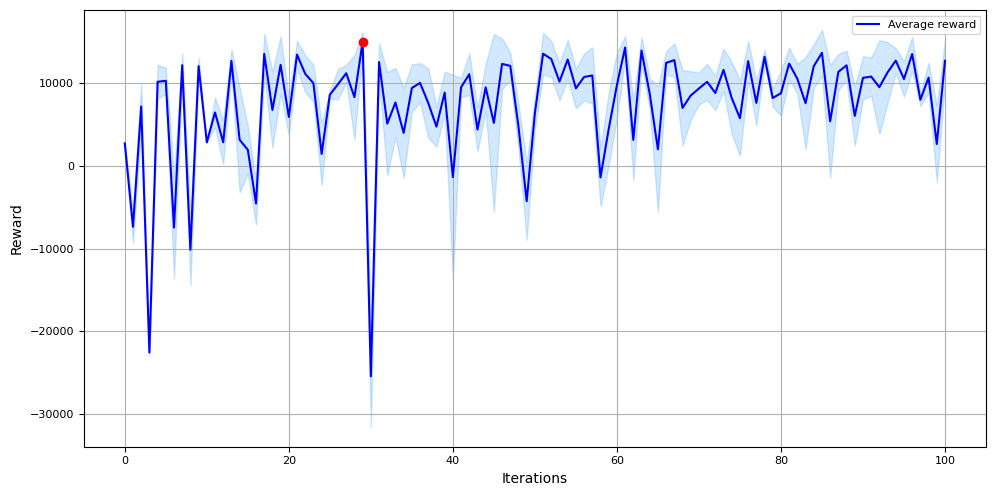

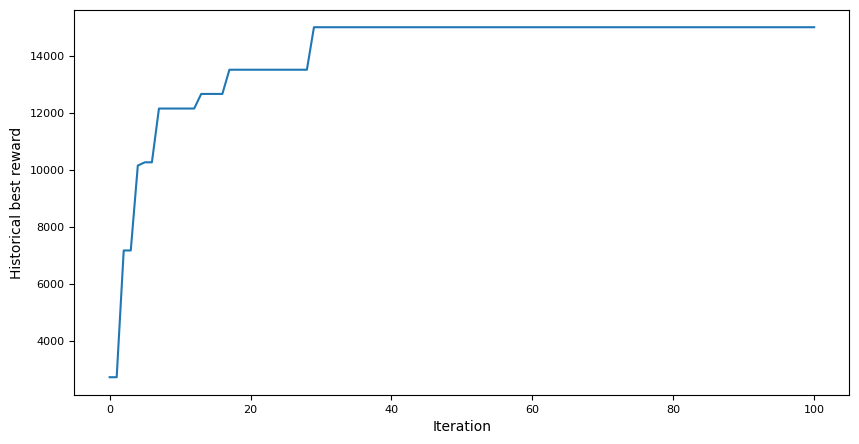

In [110]:
# Plot solution evolution per iteration
plot_reward_evolution(list(range(len(plot_info['reward_history']))), plot_info['reward_history'], reward_std=plot_info['std_history']);

# Plot historical best reward
plt.plot(list(range(len(plot_info['best_reward_history']))), plot_info['best_reward_history'])
plt.xlabel('Iteration')
plt.ylabel('Historical best reward');

# **5. Policy evaluation**
### **5.1. Test data**: get new demand scenarios
The variable test_demand_dataset contains 100 samples of demand scenarios, each with `env_train.n_periods` days, that will be used for testing and comparing the extrapolation capabilities of the different policies.

In [111]:
import pickle
# Open the file in binary mode
with open("test_demand_dataset.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### **5.2. Load best policy found so far**

In [112]:
best_policy = PolicyNetwork(input_size=env_train.observation_space.shape[0], output_size=env_train.action_space.shape[0]) 
best_policy.load_state_dict(torch.load(policy_model_path))

<All keys matched successfully>

### **5.3. Evaluation**
Compute the total undiscounted reward achieved by following `best_policy` under each one of the scenario sets in `test_demand_dataset`.

In [119]:
reward_list = []
for demand in test_demand_dataset:
    reward, _ = reward_fcn(best_policy, env_train, num_episodes=1, demand=demand)
    reward_list.append(reward)

print("Performance of the inventory management policy in the test set:\n - Average reward: {:.0f}\n - Reward standard deviation: {:.2f}".format(np.mean(reward_list), np.std(reward_list)))

Performance of the inventory management policy in the test set:
 - Average reward: 12767
 - Reward standard deviation: 2173.71


##### **Results visualization**
Plot the distribution of rewards and compare your results to those obtained with two other benchmarking poilicies, which have been evaluated using the same `test_demand_dataset`. 

The policies considered for benchmarking are:
* A neural network with the same architecture as the one used in this notebook that has been trained using the algorithm Simulated Annealing.
* An (s,S)-policy, which is a simple heuristic strategy where an order is placed to bring the inventory up to a target maximum level (S) only when the on-hand inventory, or inventory position, falls to or below a reorder point (s).

In [115]:
with open('benchmarking_policies.dat', 'rb') as f:
    reward_list_sS = pickle.load(f)
    reward_list_SA = pickle.load(f)

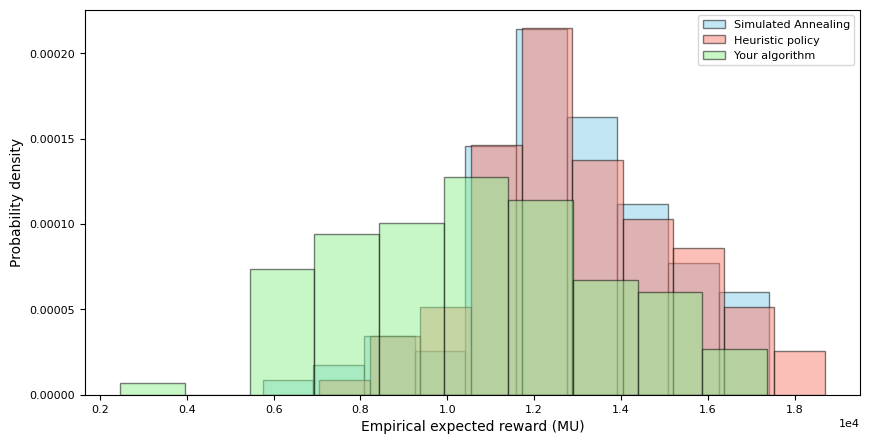

In [116]:
plot_reward_distribution(np.vstack([reward_list,reward_list_sS,reward_list_LS]).T, labels=['Simulated Annealing', 'Heuristic policy','Your algorithm'])